In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar

from src.ImUtils import commonStackReader
from src.Segmentation3D import get_voxel_size_35mm, scale_refractive

In [4]:
# experimental parameters
vox_to_um    = get_voxel_size_35mm()
tomo_scaling = 10_000
n_cell       = 1.38

In [5]:
# import data
dir  = '../../data/Tomocube/MDCK_10.02.2025/A2P1'
file = '250210.113448.MDCK dynamics.001.MDCK B.A2.T001P01_HT3D_0'

stack = commonStackReader(f"{dir}/{file}.tiff")

# scale to mean around 1.38
stack = scale_refractive(stack)


# load pickle from segmentation
with open(f"../../data/Tomocube/MDCK_10.02.2025/A2P1/mhds/lists_for_plotting.pkl", 'rb') as handle:
    lists = pickle.load(handle)

In [6]:
# prepare image data
y_min = 100
y_max = 200
im = np.mean(stack[:, y_min:y_max], axis=1)

# define ROI to enforce equal aspect ratio (in µm)
z_min = 25
z_max = len(im) - z_min
xy_to_z = 1.75

z_range = z_max - z_min
x_range = int(xy_to_z * z_range * vox_to_um[0] / vox_to_um[1])

# cut out ROI
im = im[z_min:z_max, :x_range]

In [7]:
# prepare lineplot
 
# cell bottom z-slice
z0 = (33 + 0.5 - z_min) * vox_to_um[0]

# refractive index along z and derivative. mean is taken over frames
n_z   = np.mean(lists['ri_z_list'],   axis=0)[z_min:z_max]
dn_dz = np.mean(lists['dri_dz_list'], axis=0)[z_min:z_max-1]

# corresponding std
n_err  = np.std(lists['ri_z_list'],   axis=0)[z_min:z_max]
dn_err = np.std(lists['dri_dz_list'], axis=0)[z_min:z_max-1]


# corresponding z-slices
z_arr  = vox_to_um[0] * np.arange(z_range)
dz_arr = vox_to_um[0] *(np.arange(z_range - 1) + 0.5)
z0_arr = np.ones_like(z_arr) * z0

# line in imshow
z0_im  = np.ones(x_range) * z0
xy_arr = np.arange(0, x_range) * vox_to_um[1]

In [8]:
# prepare threshold plot

# probability threshold
p_c = 0.7375

# lists for plotting
prob_c = lists['thresholds']
dims   = lists['cell_prob_shape']

# compute fraction of voxels
N_voxels = dims[0] * dims[1] * dims[2]
f_cell_above = lists['sum_above'] / N_voxels
f_cell_total = (lists['sum_below'] + f_cell_above) / N_voxels

" compute magnitude of derivative"
df_dp = -np.diff(f_cell_above) / np.diff(prob_c)
p_arr = prob_c[:-1] + (prob_c[1]-prob_c[0]) / 2

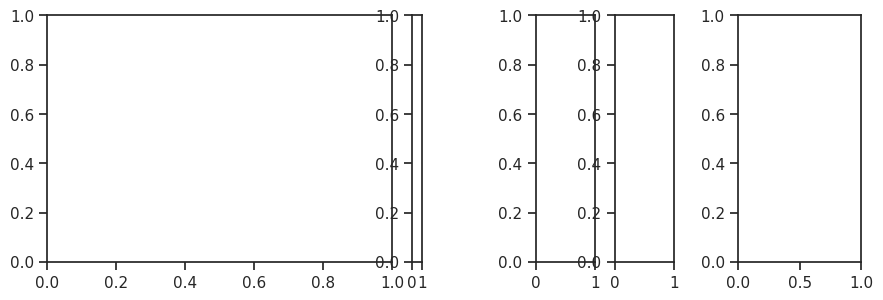

In [9]:
# define figure
w = 10.5
h = 3.2

#color = "crimson"
width_ratios = [7, 0.2, 1.5, 1.2, 1.2, 0.5, 2.5]

# define the GridSpec layout
gs = gridspec.GridSpec(1, 7, width_ratios=width_ratios)
gs.update(wspace=0.2, hspace=0.2)

# create figure
fig = plt.figure(figsize=(w,h))
sns.set_theme(style='ticks', palette='muted', font_scale=1)

# create subfigures
imx = fig.add_subplot(gs[0])
cb  = fig.add_subplot(gs[1])
p0  = fig.add_subplot(gs[3], sharey=imx)
p1  = fig.add_subplot(gs[4], sharey=imx)
p2  = fig.add_subplot(gs[6]) 
# dummy = fig.add_subplot(gs[5])

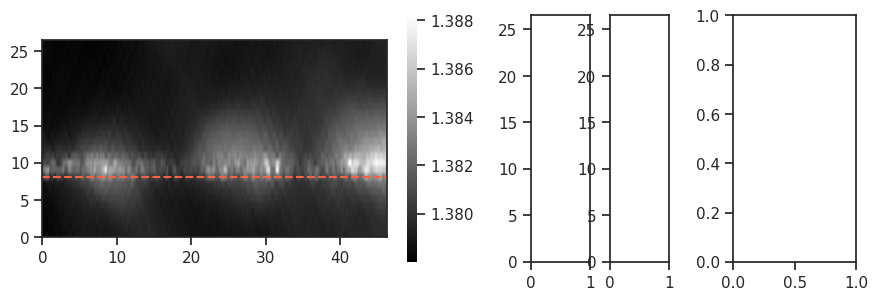

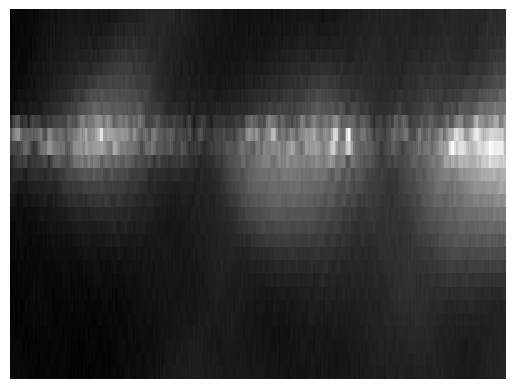

In [10]:
# plot image of output from tomocube
extent = [0, len(im[0]) * vox_to_um[1], 0, len(im) * vox_to_um[0]]

imx.imshow(im, cmap="gray", origin="lower", aspect="equal", extent=extent)
sns.heatmap(im, ax=None, square=False, cmap="gray", xticklabels=False, yticklabels=False, cbar_ax=cb);

# plot zero level as line
imx.plot(xy_arr, z0_im, '--',     color="tomato", alpha=1, lw=1.5)


fig

In [11]:
p0.errorbar(n_z,   z_arr,  xerr=n_err,  fmt=".", color="k", elinewidth=1, ms=4, capsize=1)
p1.errorbar(dn_dz, dz_arr, xerr=dn_err, fmt=".", color="k", elinewidth=1, ms=4, capsize=1)

p0.hlines(z0, np.min(n_z),   np.max(n_z),   ls="dashed", color="tomato", lw=1.5)
p1.hlines(z0, np.min(dn_dz), np.max(dn_dz), ls="dashed", color="tomato", lw=1.5)

#p0.set(ylim=(z_min, z_max))
#p0.set_yticks([20, 30, 40, 50])
p0.axes.get_xaxis().set_visible(False)
p1.axes.get_xaxis().set_visible(False)
p1.axes.get_yaxis().set_visible(False)

sns.despine(ax=p0)
sns.despine(ax=p1)

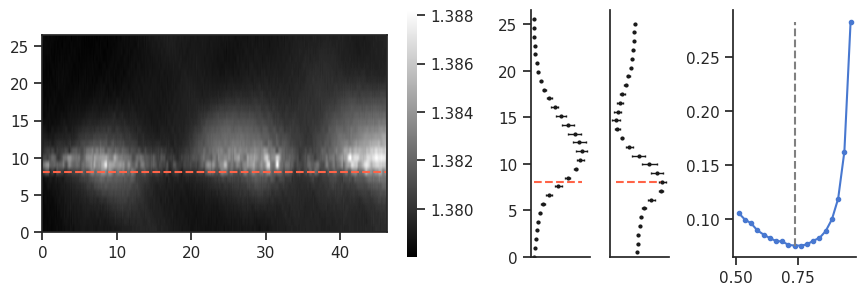

In [12]:
p2.plot(p_arr, df_dp, '.-')
p2.vlines(p_c, df_dp.min(), df_dp.max(), linestyle="dashed", linewidth=1.5, color="gray")

sns.despine(ax=p2)
fig

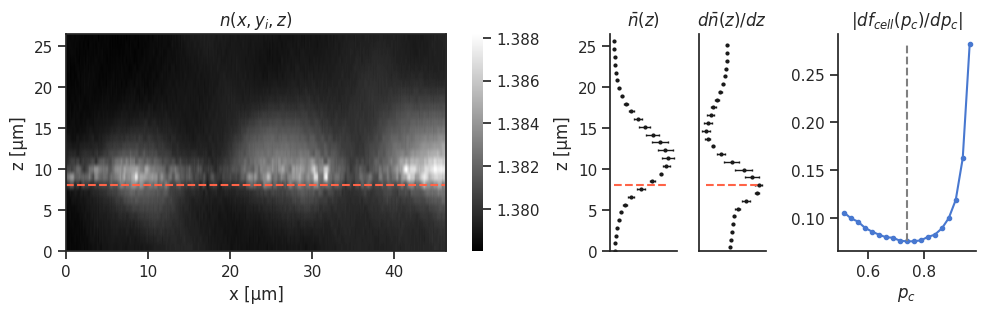

In [15]:
p0.set(title=r"$\bar{n}(z)$", ylabel="z [µm]")
p1.set(title=r"$d\bar{n}(z)/dz$")
p2.set(title=r"$|df_{cell}(p_c)/dp_c|$",   xlabel=r"$p_c$")

imx.set(title =r"$n(x,y_i, z)$",
        xlabel="x [µm]", 
        ylabel="z [µm]")

#fig.tight_layout(rect=[-0.1, 0, 1, 1])
fig

In [14]:
fig.subplots_adjust(left=0.08, right=0.95, bottom=0.2)
fig.savefig(f"../../figs/illustrations/image_preprocessing_cell_bottom.png", dpi=300)